In [1]:
import os
os.chdir("../")
%env CUDA_VISIBLE_DEVICES=0
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=0


### Neural Computation Paper Figures

In [2]:
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FormatStrFormatter
import tensorflow as tf
from data.dataset import Dataset
import data.data_selector as ds
import utils.data_processing as dp
import utils.plot_functions as pf
import analysis.analysis_picker as ap

### Parameters

In [3]:
figsize = (8, 8)
fontsize = 16
dpi = 200

In [4]:
class lca_512_vh_params(object):
  def __init__(self):
    self.model_type = "lca"
    self.model_name = "lca_512_vh"
    self.display_name = "Sparse Coding 512"
    self.version = "0.0"
    self.save_info = "analysis_train_carlini_targeted"
    self.overwrite_analysis_log = False

class lca_768_vh_params(object):
  def __init__(self):
    self.model_type = "lca"
    self.model_name = "lca_768_vh"
    self.display_name = "Sparse Coding 768"
    self.version = "0.0"
    self.save_info = "analysis_train_carlini_targeted"
    self.overwrite_analysis_log = False

class lca_1024_vh_params(object):
  def __init__(self):
    self.model_type = "lca"
    self.model_name = "lca_1024_vh"
    self.display_name = "Sparse Coding 1024"
    self.version = "0.0"
    self.save_info = "analysis_train_carlini_targeted"
    self.overwrite_analysis_log = False

class sae_768_vh_params(object):
  def __init__(self):
    self.model_type = "sae"
    self.model_name = "sae_768_vh"
    self.display_name = "Sparse Autoencoder"
    self.version = "1.0"
    self.save_info = "analysis_train_kurakin_targeted"
    self.overwrite_analysis_log = False

class rica_768_vh_params(object):
  def __init__(self):
    self.model_type = "rica"
    self.model_name = "rica_768_vh"
    self.display_name = "Linear Autoencoder"
    self.version = "0.0"
    self.save_info = "analysis_train_kurakin_targeted"
    self.overwrite_analysis_log = False

class ae_768_vh_params(object):
  def __init__(self):
    self.model_type = "ae"
    self.model_name = "ae_768_vh"
    self.display_name = "ReLU Autoencoder"
    self.version = "0.0"
    self.save_info = "analysis_train_kurakin_targeted"
    self.overwrite_analysis_log = False

class lca_768_mnist_params(object):
  def __init__(self):
    self.model_type = "lca"
    self.model_name = "lca_768_mnist"
    self.display_name = "Sparse Coding 768"
    self.version = "0.0"
    self.save_info = "analysis_train_kurakin_targeted"
    self.overwrite_analysis_log = False

class lca_1536_mnist_params(object):
  def __init__(self):
    self.model_type = "lca"
    self.model_name = "lca_1536_mnist"
    self.display_name = "Sparse Coding 1536"
    self.version = "0.0"
    self.save_info = "analysis_test_carlini_targeted"
    self.overwrite_analysis_log = False

class ae_768_mnist_params(object):
  def __init__(self):
    self.model_type = "ae"
    self.model_name = "ae_768_mnist"
    self.display_name = "ReLU Autoencoder"
    self.version = "0.0"
    self.save_info = "analysis_test_carlini_targeted"
    self.overwrite_analysis_log = False

class sae_768_mnist_params(object):
  def __init__(self):
    self.model_type = "sae"
    self.model_name = "sae_768_mnist"
    self.display_name = "Sparse Autoencoder"
    self.version = "0.0"
    self.save_info = "analysis_test_carlini_targeted"
    self.overwrite_analysis_log = False

class rica_768_mnist_params(object):
  def __init__(self):
    self.model_type = "rica"
    self.model_name = "rica_768_mnist"
    self.display_name = "Linear Autoencoder"
    self.version = "0.0"
    self.save_info = "analysis_train_kurakin_targeted"
    self.overwrite_analysis_log = False

class ae_deep_mnist_params(object):
  def __init__(self):
    self.model_type = "ae"
    self.model_name = "ae_deep_mnist"
    self.display_name = "ReLU Autoencoder"
    self.version = "0.0"
    self.save_info = "analysis_test_carlini_targeted"
    self.overwrite_analysis_log = False

### Iso-contour activations comparison

In [60]:
#params_list = [rica_768_vh_params(), ae_768_vh_params(), sae_768_vh_params(), lca_768_vh_params()]
params_list = [rica_768_mnist_params(), ae_768_mnist_params(), sae_768_mnist_params(), lca_1536_mnist_params()]
for params in params_list:
  params.model_dir = (os.path.expanduser("~")+"/Work/Projects/"+params.model_name)
analyzer_list = [ap.get_analyzer(params.model_type) for params in params_list]
for analyzer, params in zip(analyzer_list, params_list):
  analyzer.setup(params)
  analyzer.model.setup(analyzer.model_params)
  analyzer.load_analysis(save_info=params.save_info)
  analyzer.model_name = params.model_name

In [61]:
for analyzer in analyzer_list:
  run_params = np.load(analyzer.analysis_out_dir+"savefiles/iso_params_"+analyzer.analysis_params.save_info+".npz")["data"].item()
  min_angle = run_params["min_angle"]
  max_angle = run_params["max_angle"]
  num_neurons = run_params["num_neurons"]
  use_bf_stats = run_params["use_bf_stats"]
  num_comparison_vectors = run_params["num_comparison_vects"]
  x_range = run_params["x_range"]
  y_range = run_params["y_range"]
  num_images = run_params["num_images"]

  iso_vectors = np.load(analyzer.analysis_out_dir+"savefiles/iso_vectors_"+analyzer.analysis_params.save_info+".npz")["data"].item()
  analyzer.target_neuron_ids = iso_vectors["target_neuron_ids"]
  analyzer.comparison_neuron_ids = iso_vectors["comparison_neuron_ids"]
  analyzer.target_vectors = iso_vectors["target_vectors"]
  analyzer.rand_orth_vectors = iso_vectors["rand_orth_vectors"]
  analyzer.comparison_vectors = iso_vectors["comparison_vectors"]

  analyzer.comp_activations = np.load(analyzer.analysis_out_dir+"savefiles/iso_comp_activations_"+analyzer.analysis_params.save_info+".npz")["data"]
  analyzer.comp_contour_dataset = np.load(analyzer.analysis_out_dir+"savefiles/iso_comp_contour_dataset_"+analyzer.analysis_params.save_info+".npz")["data"].item()
  analyzer.rand_activations = np.load(analyzer.analysis_out_dir+"savefiles/iso_rand_activations_"+analyzer.analysis_params.save_info+".npz")["data"]
  analyzer.rand_contour_dataset = np.load(analyzer.analysis_out_dir+"savefiles/iso_rand_contour_dataset_"+analyzer.analysis_params.save_info+".npz")["data"].item()
  

In [62]:
def plot_goup_iso_contours(analyzer_list, neuron_indices, orth_indices, num_levels):
  num_neurons = len(neuron_indices)
  num_plots_y = np.int32(np.ceil(np.sqrt(num_neurons)))
  num_plots_x = np.int32(np.ceil(np.sqrt(num_neurons)))+1 # +cbar col
  gs_widths = [1 for _ in range(num_plots_x-1)]+[0.1]
  gs0 = gridspec.GridSpec(num_plots_y, num_plots_x, width_ratios=gs_widths, hspace=-0.1, wspace=-0.3)
  
  vmin = np.min([analyzer.comp_activations for analyzer in analyzer_list])
  vmax = np.max([analyzer.comp_activations for analyzer in analyzer_list])
  levels = np.linspace(vmin, vmax, num_levels)
  
  cmap = plt.get_cmap("cividis")#"Greys_r")#"viridis")
  cNorm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
  scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cmap)
  
  fig = plt.figure(figsize=figsize, dpi=dpi)
  analyzer_index = 0
  for plot_id in  np.ndindex((num_plots_y, num_plots_x-1)):
    (y_id, x_id) = plot_id
    if type(neuron_indices) == list:
      analyzer_neuron_index = neuron_indices[analyzer_index]
    else:
      analyzer_neuron_index = neuron_indices
    if type(orth_indices) == list:
      analyzer_orth_index = orth_indices[analyzer_index]
    else:
      analyzer_orth_index = orth_indices
    analyzer = analyzer_list[analyzer_index]
    gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, gs0[plot_id], wspace=-0.15, hspace=0.1)
    curve_ax = pf.clear_axis(fig.add_subplot(gs1[0]))
    curve_ax.set_title(analyzer.analysis_params.display_name, fontsize=fontsize)

    norm_activity = analyzer.comp_activations[analyzer_neuron_index, analyzer_orth_index, ...]
    x_mesh, y_mesh = np.meshgrid(analyzer.comp_contour_dataset["x_pts"], analyzer.comp_contour_dataset["y_pts"])
    contsf = curve_ax.contourf(x_mesh, y_mesh, norm_activity,
      levels=levels, vmin=vmin, vmax=vmax, alpha=1.0, antialiased=True, cmap=cmap)

    proj_target = analyzer.comp_contour_dataset["proj_target_neuron"][analyzer_neuron_index][analyzer_orth_index]
    target_vector_x = proj_target[0].item()
    target_vector_y = proj_target[1].item()
    curve_ax.arrow(0, 0, target_vector_x, target_vector_y,
      width=0.00, head_width=0.15, head_length=0.15, fc='k', ec='k',
      linestyle='-', linewidth=3)
    
    tenth_range_shift = ((max(x_range) - min(x_range))/10)
    text_handle = curve_ax.text(target_vector_x+(tenth_range_shift*0.3),
      target_vector_y+(tenth_range_shift*0.7),
      r"$\Phi_{k}$",
      fontsize=fontsize,
      horizontalalignment='center',
      verticalalignment='center',
      #bbox=dict(boxstyle="tightbox,pad=0.,rounding_size=0.2,rescale=1.0",
      #  ec=(1., 1.0, 1.0),
      #  fc=(1., 1.0, 1.0),
      #  alpha=0.4),
      )

    proj_comparison = analyzer.comp_contour_dataset["proj_comparison_neuron"][analyzer_neuron_index][analyzer_orth_index]
    comparison_vector_x = proj_comparison[0].item()
    comparison_vector_y = proj_comparison[1].item()
    curve_ax.arrow(0, 0, comparison_vector_x, comparison_vector_y,
      width=0.00, head_width=0.15, head_length=0.15, fc='k', ec='k',
      linestyle="dotted", linewidth=1.0)
    text_handle = curve_ax.text(comparison_vector_x+(tenth_range_shift*0.3),
      comparison_vector_y+(tenth_range_shift*0.7),
      r"$\Phi_{j}$",
      fontsize=fontsize,
      horizontalalignment='center',
      verticalalignment='center',
      #bbox=dict(boxstyle="tightbox,pad=0.,rounding_size=0.2,rescale=1.0",
      #  ec=(1., 1., 1.),
      #  fc=(1., 1., 1.)),
      )

    #for proj_alt in analyzer.comp_contour_dataset["proj_comparison_neuron"][analyzer_neuron_index]:
    #  if not np.all(proj_alt == proj_comparison):
    #    curve_ax.arrow(0, 0, proj_alt[0].item(), proj_alt[1].item(),
    #      width=0.00, head_width=0.15, head_length=0.15, fc='w', ec='w',
    #      linestyle="dashed", linewidth=1.0, alpha=0.9)

    proj_orth = analyzer.comp_contour_dataset["proj_orth_vect"][analyzer_neuron_index][analyzer_orth_index]
    orth_vector_x = proj_orth[0].item()
    orth_vector_y = proj_orth[1].item()
    curve_ax.arrow(0, 0, orth_vector_x, orth_vector_y,
      width=0.00, head_width=0.10, head_length=0.10, fc='k', ec='k',
      linestyle="-", linewidth=3)
    text_handle = curve_ax.text(orth_vector_x+(tenth_range_shift*0.3),
      orth_vector_y+(tenth_range_shift*0.7),
      #r"$\mathbf{\nu}$",
      r"$\nu$",
      fontsize=fontsize,
      horizontalalignment='center',
      verticalalignment='center',
      #bbox=dict(boxstyle="tightbox,pad=0.,rounding_size=0.2,rescale=1.0",
      #  ec=(1., 1.0, 1.0),
      #  fc=(1., 1.0, 1.0),
      #  alpha=0.4),
      )

    curve_ax.plot(x_range, [0,0], color='k')
    curve_ax.plot([0,0], y_range, color='k')
    #curve_ax.set_xticks(x_range)
    #curve_ax.set_yticks([0])
    #curve_ax.set_yticks(y_range)
    #curve_ax.tick_params(axis="both", bottom=True, top=False, left=True, right=False)
    #curve_ax.get_xaxis().set_visible(True)
    #curve_ax.get_yaxis().set_visible(True)
    #curve_ax.set_xticklabels(x_range, fontsize=fontsize)
    #curve_ax.set_yticklabels(y_range, fontsize=fontsize)
    
    curve_ax.set_aspect("equal")

    #gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, gs1[1], wspace=0.0, hspace=0.5)#-0.55)
    #target_vect_ax = pf.clear_axis(fig.add_subplot(gs2[0]))
    #target_vect_ax.imshow(analyzer.bf_stats["basis_functions"][analyzer.target_neuron_ids[0]], cmap="Greys_r")
    #target_vect_ax.set_title("Primary\nBasis Function", color='r', fontsize=16)
    #comparison_vect_ax = pf.clear_axis(fig.add_subplot(gs2[1]))
    #comparison_vect_ax.imshow(analyzer.bf_stats["basis_functions"][analyzer.comparison_neuron_ids[0][0]], cmap="Greys_r")
    #comparison_vect_ax.set_title("Comparison\nBasis Function", color='k', fontsize=16)

    analyzer_index += 1
    
  #cbar = pf.add_colorbar_to_ax(contsf, curve_ax, aspect=20, pad_fraction=0.5, labelsize=fontsize, ticks=[vmin, vmax])
  #cbar.ax.set_yticklabels(["{:.0f}".format(vmin), "{:.0f}".format(vmax)])
  scalarMap._A = []
  #aspect=((xmax-xmin)/(ymax-ymin))
  #ax = pf.clear_axis(fig.add_subplot(gs0[0, -1]))
  #TODO: Get y_id=0; y_id=-1 axis coordinates to calulate top & extent of colorbar
  ax = pf.clear_axis(fig.add_axes([0.0, 0.33, 0.11, 0.70]))
  cbar = ax.figure.colorbar(scalarMap, ax=ax, ticks=[vmin, vmax], aspect=10)
  cbar.ax.tick_params(labelleft=True, labelright=False, left=True, right=False, labelsize=fontsize)
  cbar.ax.set_yticklabels(["{:.0f}".format(vmin), "{:.0f}".format(vmax)])
  plt.show()
  return fig

In [63]:
neuron_indices = [0, 0, 0, 1]
orth_indices = [0, 0, 0, 37]
num_plots_y = 2
num_plots_x = 2
num_levels = 10

fig = plot_goup_iso_contours(analyzer_list, neuron_indices, orth_indices, num_levels)
for analyzer, neuron_index, orth_index in zip(analyzer_list, neuron_indices, orth_indices):
  for ext in [".png", ".eps"]:
    neuron_str = str(analyzer.target_neuron_ids[neuron_index])
    orth_str = str(analyzer.comparison_neuron_ids[orth_index])
    save_name = (analyzer.analysis_out_dir+"/vis/iso_contour_comparison_bf0id"+neuron_str+"_bf1id"+orth_str
      +"_"+analyzer.analysis_params.save_info+ext)
    fig.savefig(save_name, dpi=dpi, transparent=True, bbox_inches="tight", pad_inches=0.01)

ValueError: could not broadcast input array from shape (2,767,30,30) into shape (2)

### Curvature histogram

In [64]:
#params_list = [lca_512_vh_params(), lca_768_vh_params(), lca_1024_vh_params()]
params_list = [lca_768_mnist_params(), lca_1536_mnist_params()]
for params in params_list:
  params.model_dir = (os.path.expanduser("~")+"/Work/Projects/"+params.model_name)
analyzer_list = [ap.get_analyzer(params.model_type) for params in params_list]
for analyzer, params in zip(analyzer_list, params_list):
  analyzer.setup(params)
  analyzer.model.setup(analyzer.model_params)
  analyzer.load_analysis(save_info=params.save_info)
  analyzer.model_name = params.model_name

In [69]:
for analyzer in analyzer_list:
  run_params = np.load(analyzer.analysis_out_dir+"savefiles/iso_params_nonorm_"+analyzer.analysis_params.save_info+".npz")["data"].item()
  min_angle = run_params["min_angle"]
  max_angle = run_params["max_angle"]
  num_neurons = run_params["num_neurons"]
  use_bf_stats = run_params["use_bf_stats"]
  num_comparison_vectors = run_params["num_comparison_vects"]
  x_range = run_params["x_range"]
  y_range = run_params["y_range"]
  num_images = run_params["num_images"]
  analyzer.comp_activations = np.load(analyzer.analysis_out_dir+"savefiles/iso_comp_activations_nonorm_"+analyzer.analysis_params.save_info+".npz")["data"]
  analyzer.comp_contour_dataset = np.load(analyzer.analysis_out_dir+"savefiles/iso_comp_contour_dataset_nonorm_"+analyzer.analysis_params.save_info+".npz")["data"].item()
  analyzer.rand_activations = np.load(analyzer.analysis_out_dir+"savefiles/iso_rand_activations_nonorm_"+analyzer.analysis_params.save_info+".npz")["data"]
  analyzer.rand_contour_dataset = np.load(analyzer.analysis_out_dir+"savefiles/iso_rand_contour_dataset_nonorm_"+analyzer.analysis_params.save_info+".npz")["data"].item()
  iso_vectors = np.load(analyzer.analysis_out_dir+"savefiles/iso_vectors_"+analyzer.analysis_params.save_info+".npz")["data"].item()
  analyzer.target_neuron_ids = iso_vectors["target_neuron_ids"]
  analyzer.comparison_neuron_ids = iso_vectors["comparison_neuron_ids"]
  analyzer.target_vectors = iso_vectors["target_vectors"]
  analyzer.rand_orth_vectors = iso_vectors["rand_orth_vectors"]
  analyzer.comparison_vectors = iso_vectors["comparison_vectors"]

In [75]:
analyzer_neuron_index = 1
y_start_index = 0#int(np.sqrt(num_images)/2) # set to 1/2 of sqrt(num_images) to use only positive quadrant
slice_scale = 0.8

for analyzer in analyzer_list:
  analyzer.neuron_index = analyzer_neuron_index
  analyzer.num_neurons = analyzer.bf_stats["num_outputs"]
  analyzer.num_pixels = analyzer.bf_stats["num_inputs"]
  
  comp_x_pts = analyzer.comp_contour_dataset["x_pts"]
  rand_x_pts = analyzer.rand_contour_dataset["x_pts"]
  assert(np.all(comp_x_pts == rand_x_pts)) # This makes sure we don't need to recompute proj_datapoints for each case
  num_x_imgs = len(comp_x_pts)
  x_target = comp_x_pts[int(slice_scale * num_x_imgs)] # find a location to take a slice
  proj_datapoints = analyzer.comp_contour_dataset["proj_datapoints"]
  slice_indices = np.where(proj_datapoints[:, 0] == x_target)[0]
  analyzer.sliced_datapoints = proj_datapoints[slice_indices, :][y_start_index:, :] # slice grid
  
  analyzer.comp_curvatures = []
  analyzer.comp_fits = []
  analyzer.comp_sliced_activity = []
  analyzer.comp_delta_activity = []
  analyzer.rand_curvatures = []
  analyzer.rand_fits = []
  analyzer.rand_sliced_activity = []
  analyzer.rand_delta_activity = []
  for orth_index in range(analyzer.num_neurons-1):
    comp_activity = analyzer.comp_activations[analyzer.neuron_index, orth_index, ...].reshape([-1])
    analyzer.comp_sliced_activity.append(comp_activity[slice_indices][y_start_index:])
    coeff = np.polynomial.polynomial.polyfit(analyzer.sliced_datapoints[:, 1],
      analyzer.comp_sliced_activity[-1], deg=2) # [c0, c1, c2], where p = c0 + c1x + c2x^2
    analyzer.comp_curvatures.append(coeff[2])
    analyzer.comp_fits.append(np.polynomial.polynomial.polyval(analyzer.sliced_datapoints[:, 1], coeff))
    delta_activity = analyzer.comp_sliced_activity[-1][-1] - analyzer.comp_sliced_activity[-1][0]
    analyzer.comp_delta_activity.append(delta_activity)
    
  for orth_index in range(analyzer.num_pixels-1):
    rand_activity = analyzer.rand_activations[analyzer.neuron_index, orth_index, ...].reshape([-1])
    analyzer.rand_sliced_activity.append(rand_activity[slice_indices][y_start_index:])
    coeff = np.polynomial.polynomial.polyfit(analyzer.sliced_datapoints[:, 1],
      analyzer.rand_sliced_activity[-1], deg=2)
    analyzer.rand_curvatures.append(coeff[2])
    analyzer.rand_fits.append(np.polynomial.polynomial.polyval(analyzer.sliced_datapoints[:, 1], coeff))
    delta_activity = analyzer.rand_sliced_activity[-1][-1] - analyzer.rand_sliced_activity[-1][0]
    analyzer.rand_delta_activity.append(delta_activity)

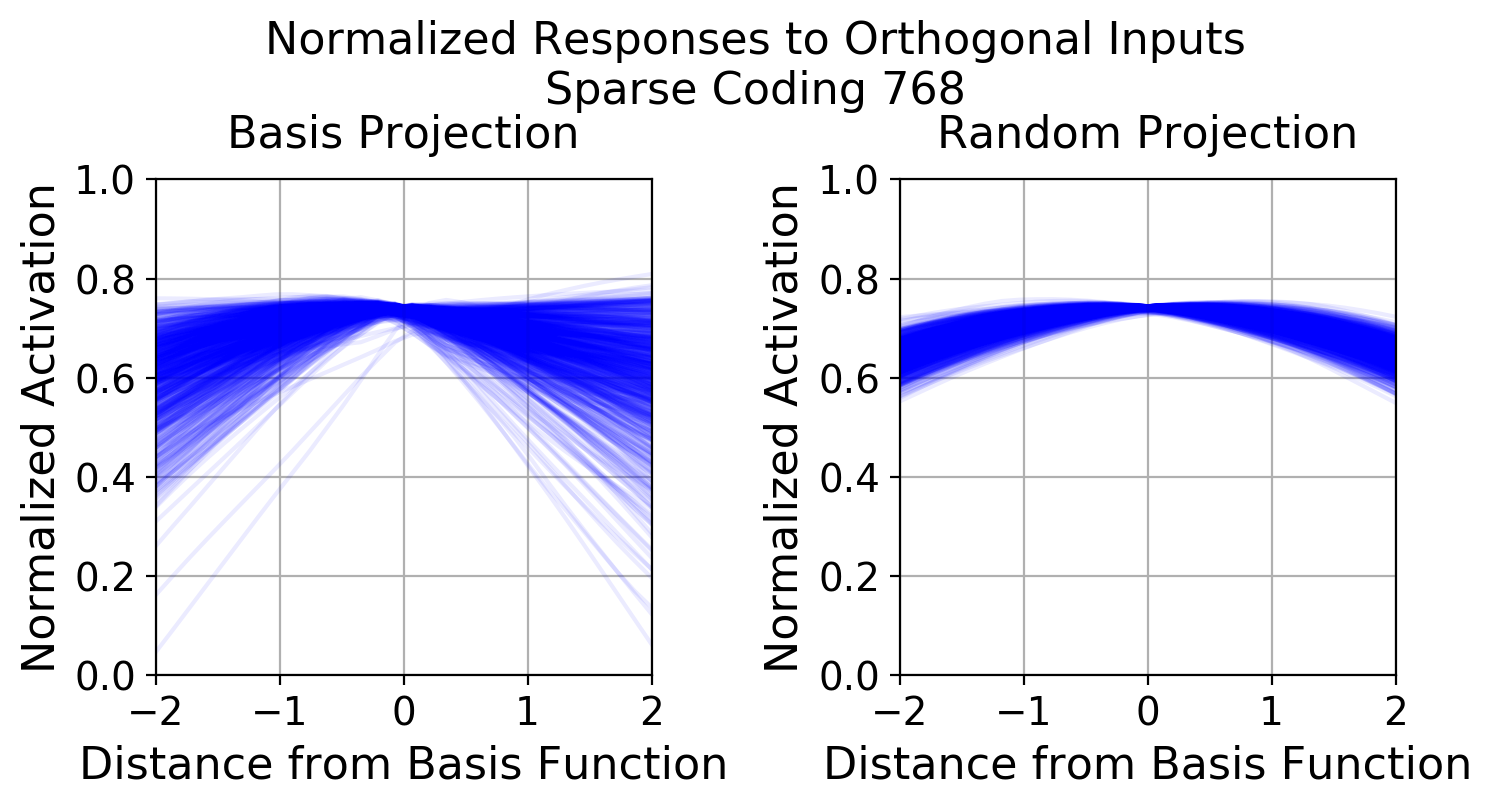

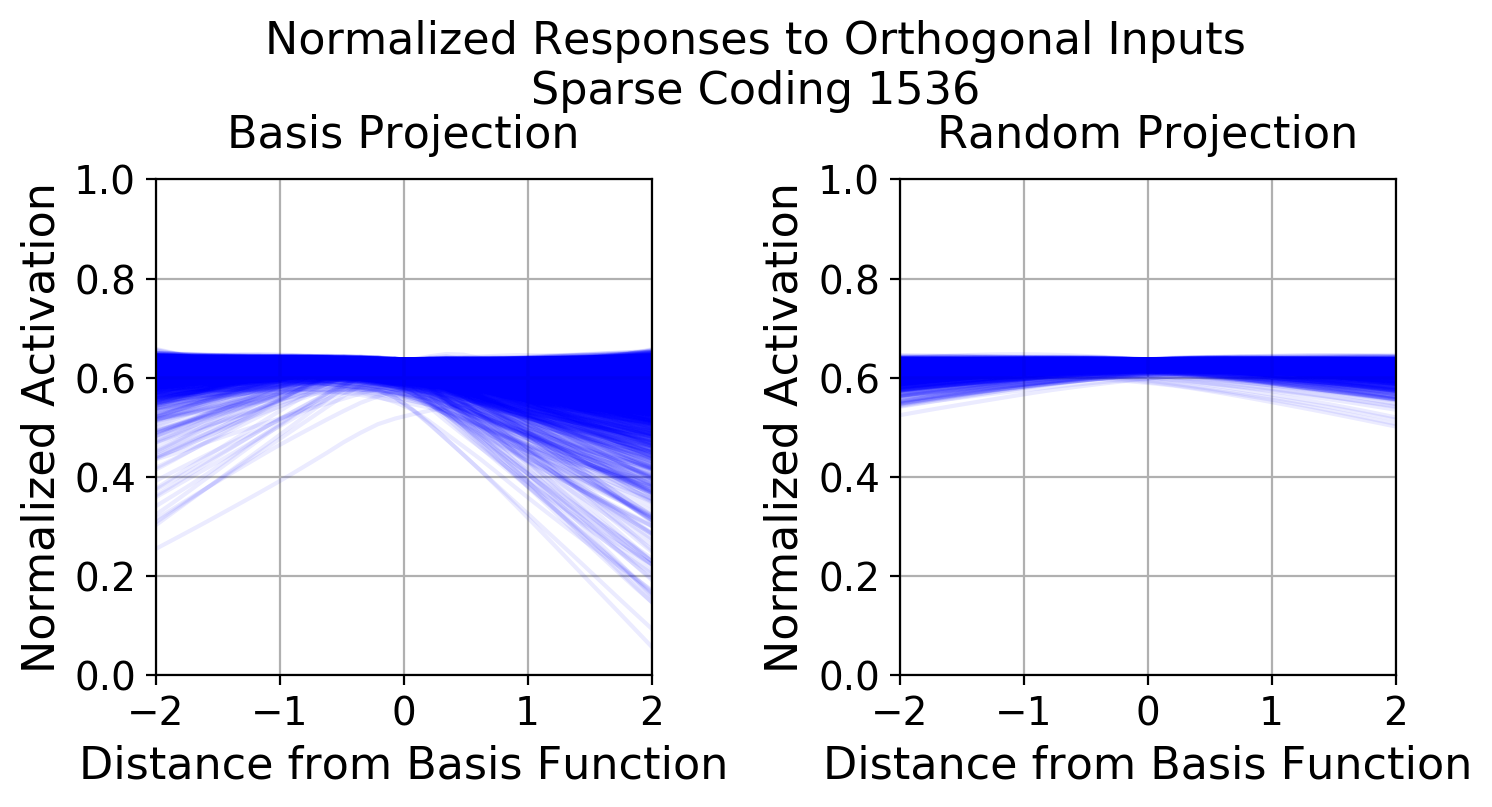

In [76]:
line_alpha = 0.08
for analyzer in analyzer_list:
  fig = plt.figure(figsize=(figsize[0], 2*figsize[1]), dpi=dpi)
  gs0 = gridspec.GridSpec(1, 2, hspace=0.0, wspace=0.5)
  axes = [fig.add_subplot(gs0[idx]) for idx in range(2)]
  for orth_index in range(analyzer.num_neurons-1):
    #if analyzer.comp_curvatures[orth_index] > 0.02:
      axes[0].plot(analyzer.sliced_datapoints[:, 1], analyzer.comp_sliced_activity[orth_index],
        color='b', alpha=line_alpha)
  for orth_index in range(analyzer.num_pixels-1):
    #if analyzer.rand_curvatures[orth_index] > 0.02:
      axes[1].plot(analyzer.sliced_datapoints[:, 1], analyzer.rand_sliced_activity[orth_index],
        color='b', alpha=line_alpha)
  for ax, title in zip(axes, ["Basis Projection", "Random Projection"]):
    ax.set_title(title, y=1.03, fontsize=fontsize)
    ax.set_ylabel("Normalized Activation", fontsize=fontsize)
    ax.set_xlabel("Distance from Basis Function", fontsize=fontsize)
    ax.grid(True)
    ax.set_ylim([0.0, 1.0])
    x_vals = analyzer.sliced_datapoints[:,1]
    ax.set_xlim([np.min(x_vals), np.max(x_vals)])
    for tick in ax.xaxis.get_major_ticks():
      tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
      tick.label.set_fontsize(14) 
    ax.set_aspect((np.max(x_vals)-np.min(x_vals)))
    ax.tick_params(labelsize=14)
  fig.suptitle("Normalized Responses to Orthogonal Inputs\n"+analyzer.analysis_params.display_name,
    y=0.63, x=0.5, fontsize=fontsize)
  neuron_str = str(analyzer.target_neuron_ids[analyzer.neuron_index])
  save_name = (analyzer.analysis_out_dir+"/vis/bf_curvatures_bfid0"+neuron_str
    +"_"+analyzer.analysis_params.save_info+".png")
  fig.savefig(save_name, transparent=True, bbox_inches="tight", pad_inches=0.01)
  plt.show()

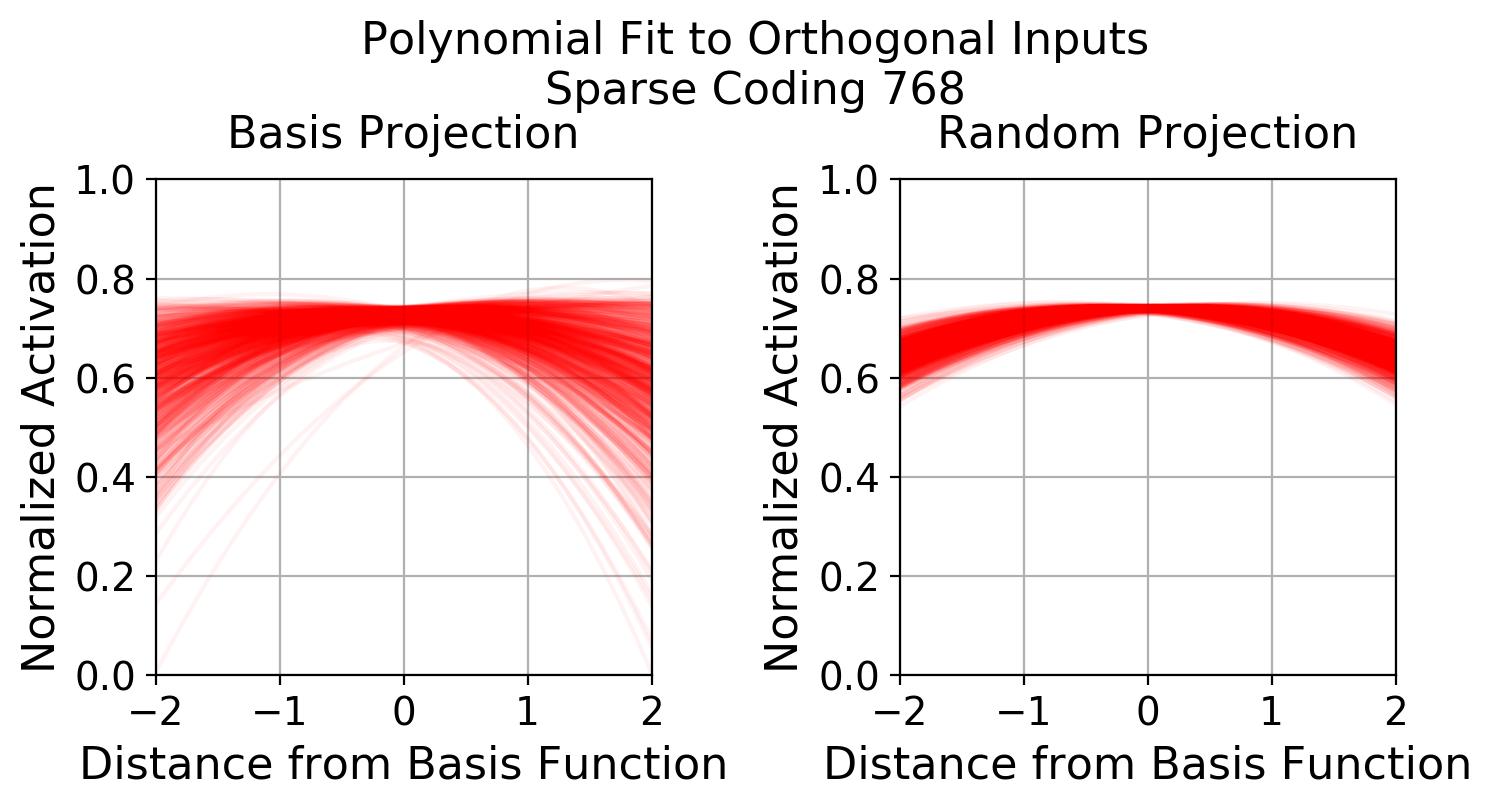

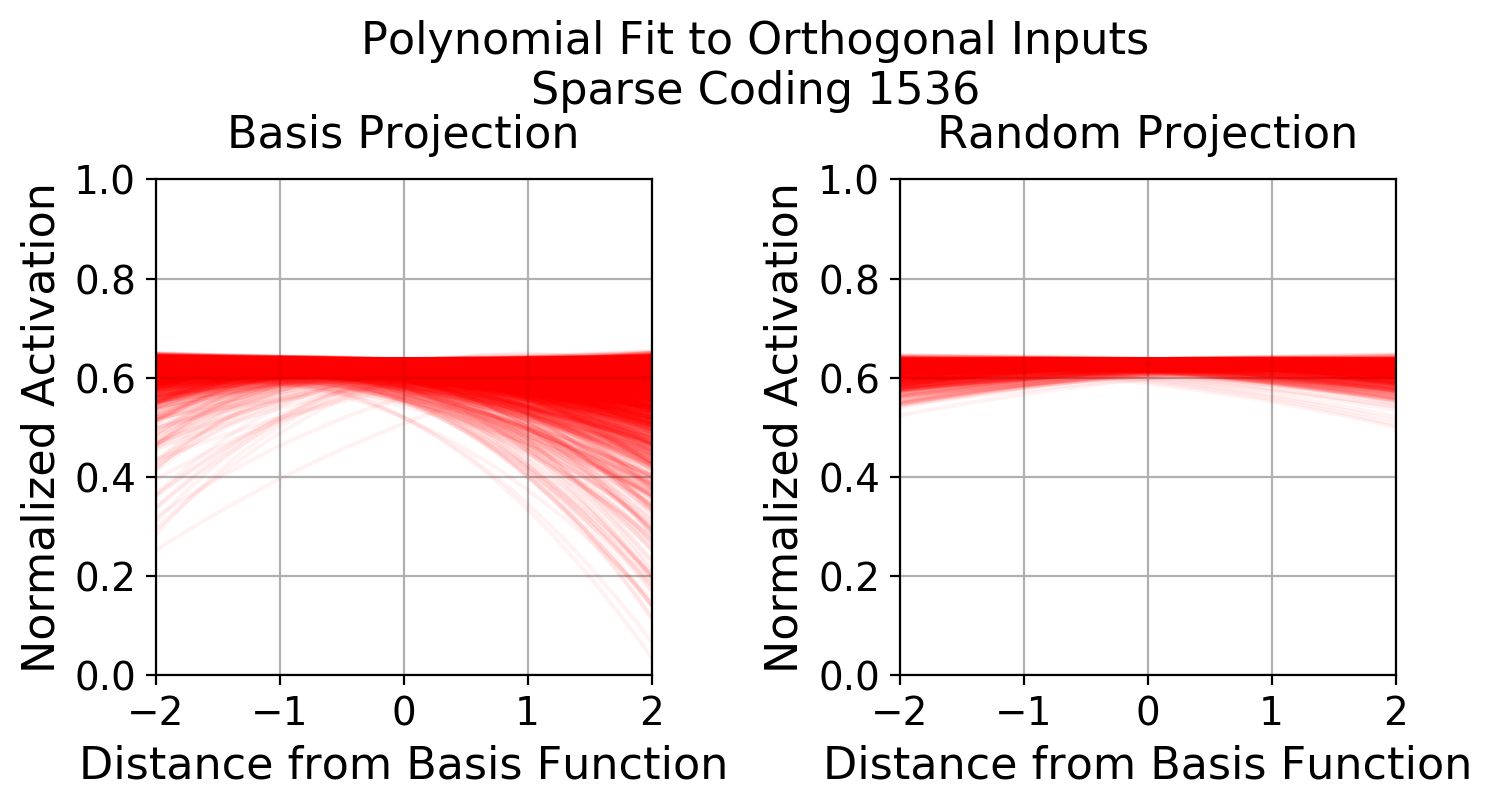

In [77]:
for analyzer in analyzer_list:
  fig = plt.figure(figsize=(figsize[0], 2*figsize[1]), dpi=dpi)
  gs0 = gridspec.GridSpec(1, 2, hspace=0.0, wspace=0.5)
  axes = [fig.add_subplot(gs0[idx]) for idx in range(2)]
  for orth_index in range(analyzer.num_neurons-1):
    axes[0].plot(analyzer.sliced_datapoints[:,1], analyzer.comp_fits[orth_index], color='r', alpha=0.05)
  for orth_index in range(analyzer.num_pixels-1):
    axes[1].plot(analyzer.sliced_datapoints[:,1], analyzer.rand_fits[orth_index], color='r', alpha=0.05)
  for ax, title in zip(axes, ["Basis Projection", "Random Projection"]):
    ax.set_title(title, y=1.03, fontsize=fontsize)
    ax.set_ylabel("Normalized Activation", fontsize=fontsize)
    ax.set_xlabel("Distance from Basis Function", fontsize=fontsize)
    ax.grid(True)
    ax.set_ylim([0.0, 1.0])
    x_vals = analyzer.sliced_datapoints[:,1]
    ax.set_xlim([np.min(x_vals), np.max(x_vals)])
    for tick in ax.xaxis.get_major_ticks():
      tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
      tick.label.set_fontsize(14) 
    ax.set_aspect((np.max(x_vals)-np.min(x_vals)))
    ax.tick_params(labelsize=14)
  fig.suptitle("Polynomial Fit to Orthogonal Inputs\n"+analyzer.analysis_params.display_name+"\n",
    y=0.63, x=0.5, fontsize=fontsize)
  save_name = (analyzer.analysis_out_dir+"/vis/bf_fit_curvatures_bfid0"+neuron_str
    +"_"+analyzer.analysis_params.save_info+".png")
  fig.savefig(save_name, transparent=True, bbox_inches="tight", pad_inches=0.01)
  plt.show()

In [78]:
def plot_curvature_histograms(hist_list, label_list, color_list, bin_centers, figsize=None):
  num_y_plots = len(hist_list)
  fig = plt.figure(figsize=figsize, dpi=dpi)
  gs0 = gridspec.GridSpec(num_y_plots, 1, hspace=0.05)
  axes = []
  axes.append(fig.add_subplot(gs0[0]))
  for plt_idx in range(1, num_y_plots):
    axes.append(fig.add_subplot(gs0[plt_idx], sharey=axes[0]))

  handles = []
  labels = []
  max_val = 0
  for axis_index, (axis_hists, axis_colors, axis_labels) in enumerate(zip(hist_list, color_list, label_list)):
    for hist, color, label in zip(axis_hists, axis_colors, axis_labels):
      axes[axis_index].plot(bin_centers, hist, color=color, linestyle="-", drawstyle="steps-mid", label=label)
      if np.max(hist) > max_val:
        max_val = np.max(hist)
    axes[axis_index].axvline(0.0, color='k', linestyle='dashed', linewidth=1)
    for tick in axes[axis_index].xaxis.get_major_ticks():
      tick.label.set_fontsize(fontsize) 
    for tick in axes[axis_index].yaxis.get_major_ticks():
      tick.label.set_fontsize(fontsize) 
    axes[axis_index].set_ylabel("Density", fontsize=fontsize)
    ax_handles, ax_labels = axes[axis_index].get_legend_handles_labels()
    handles += ax_handles
    labels += ax_labels

  axes[0].set_ylim([0.0, max_val+1])
  for axis_index in range(num_y_plots):
    ticks = range(0, int(max_val), int(max_val/4))
    axes[axis_index].set_yticks(ticks, minor=False)

  axes[0].set_xticks([], minor=True)
  axes[0].set_xticks([], minor=False)
  axes[-1].set_xticks(bin_lefts[::2], minor=True)
  axes[-1].xaxis.set_major_formatter(FormatStrFormatter("%0.3f"))

  axes[0].set_title("Histogram of Curvatures", fontsize=fontsize)
  axes[-1].set_xlabel("Curvature", fontsize=fontsize)

  legend = axes[0].legend(handles=handles, labels=labels, fontsize=fontsize,
    borderaxespad=0., bbox_to_anchor=[0.42, 0.99], framealpha=0.0)
  legend.get_frame().set_linewidth(0.0)
  for text, color in zip(legend.get_texts(), [color for sublist in color_list for color in sublist]):
    text.set_color(color)
  for item in legend.legendHandles:
    item.set_visible(False)
  plt.show()
  return fig

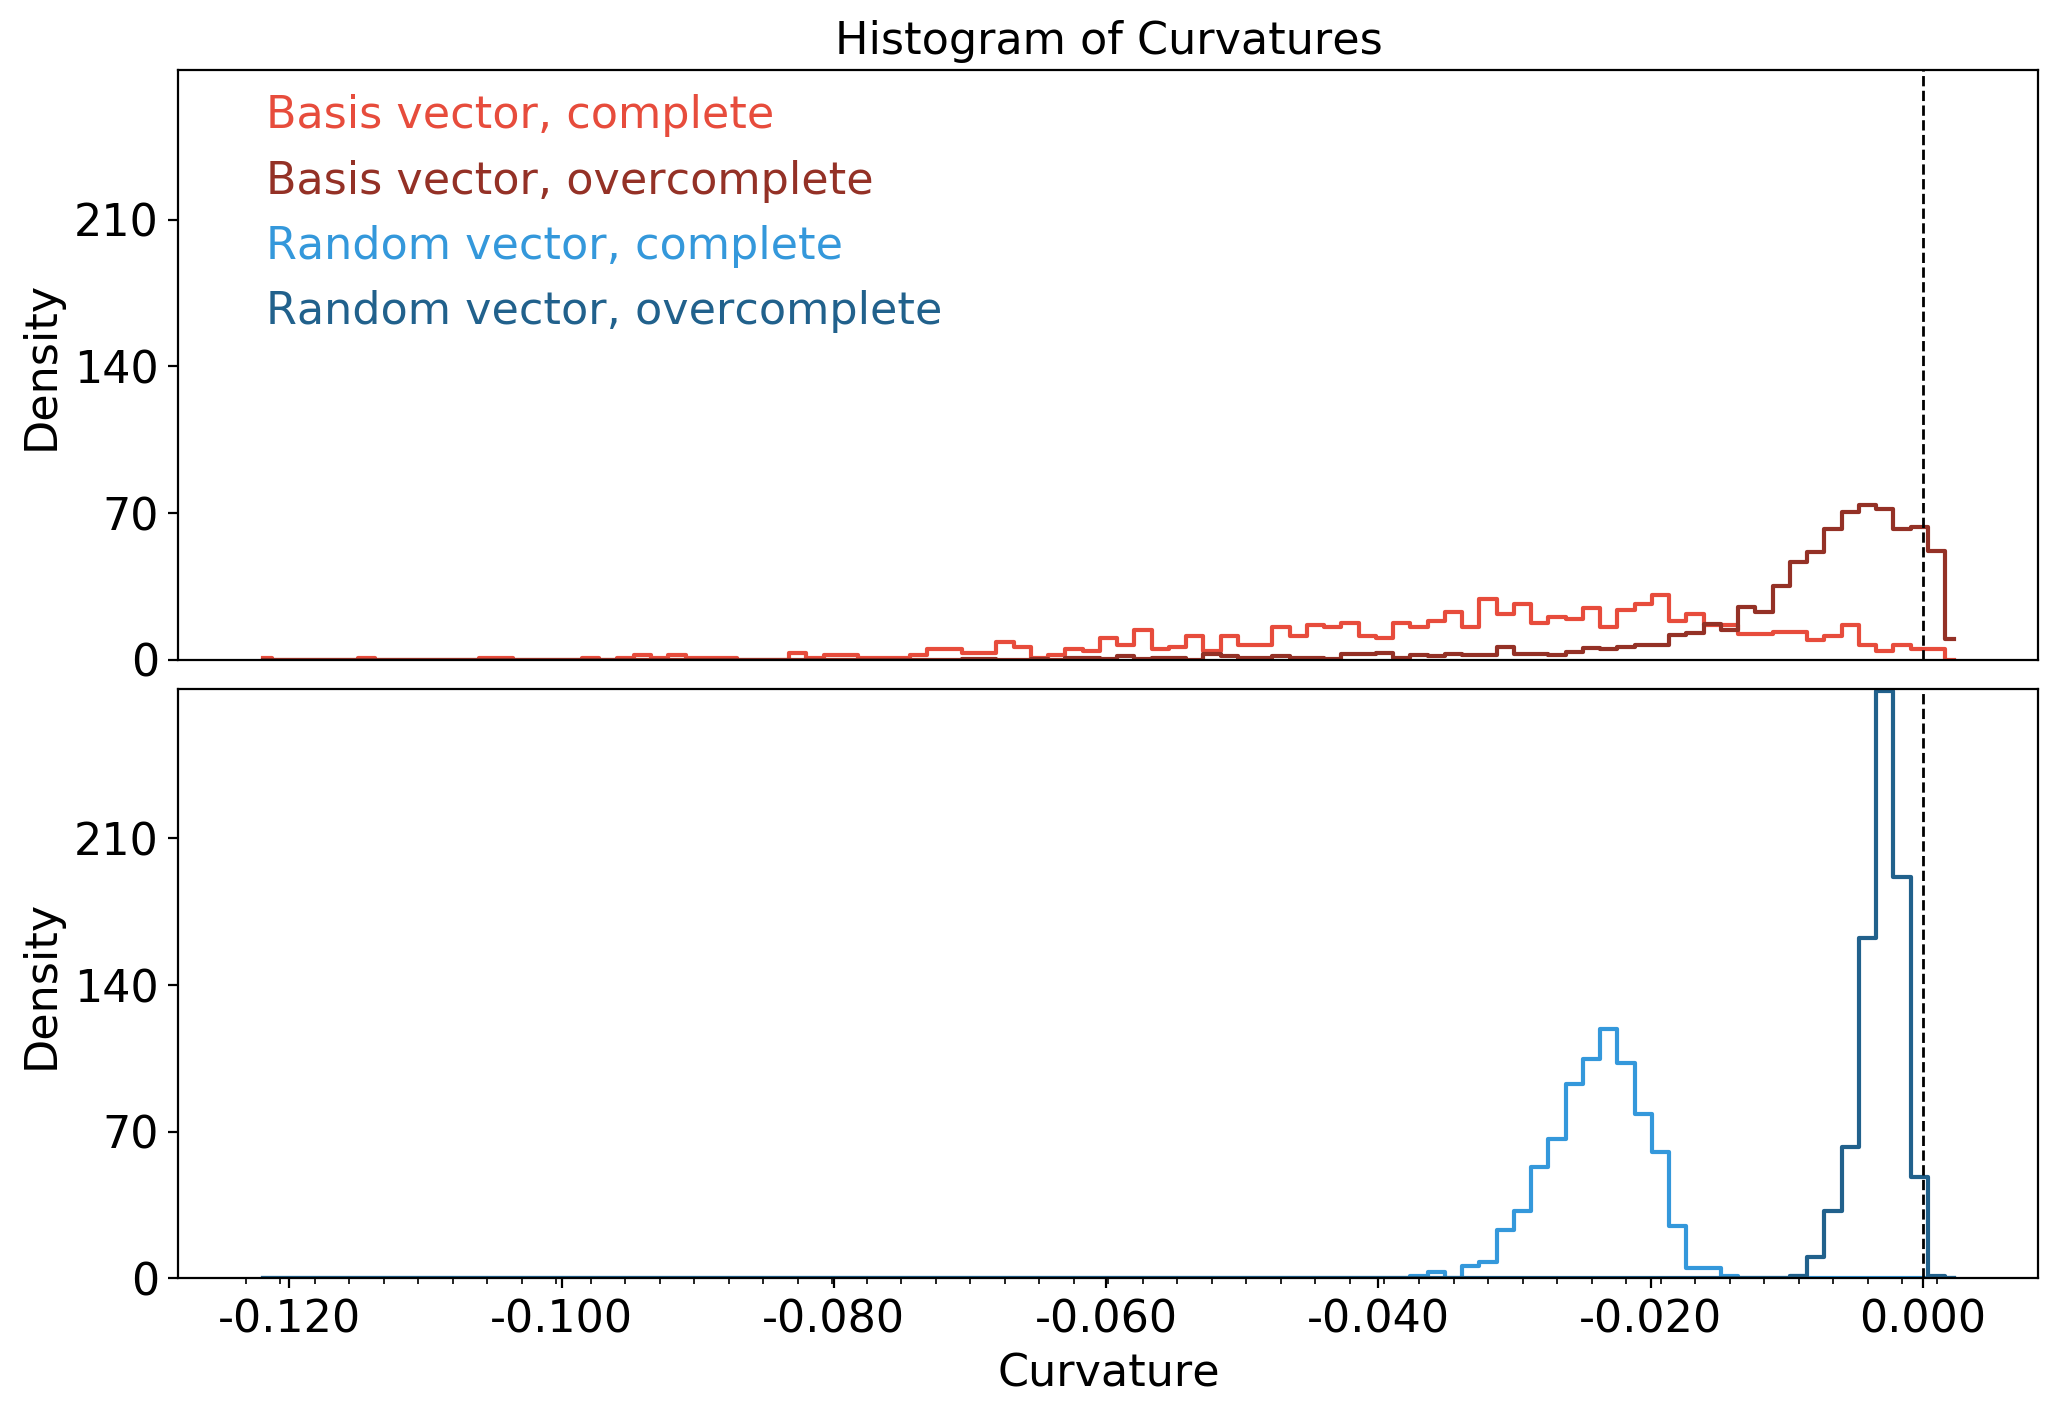

In [79]:
num_bins = 100

comp_curvatures = []
rand_curvatures = []
for analyzer in analyzer_list:
  comp_curvatures += analyzer.comp_curvatures
  rand_curvatures += analyzer.rand_curvatures
  #comp_curvatures += analyzer.comp_delta_activity
  #rand_curvatures += analyzer.rand_delta_activity
all_curvatures = comp_curvatures + rand_curvatures
bins = np.linspace(np.amin(all_curvatures), np.amax(all_curvatures), num_bins)

comp_hist_768, bin_edges = np.histogram(analyzer_list[0].comp_curvatures, bins, density=True)
rand_hist_768, _ = np.histogram(analyzer_list[0].rand_curvatures, bins, density=True)
comp_hist_1536, _ = np.histogram(analyzer_list[1].comp_curvatures, bins, density=True)
rand_hist_1536, _ = np.histogram(analyzer_list[1].rand_curvatures, bins, density=True)

#comp_hist_512, bin_edges = np.histogram(analyzer_list[0].comp_curvatures, bins, density=True)
#rand_hist_512, _ = np.histogram(analyzer_list[0].rand_curvatures, bins, density=True)
#comp_hist_768, _ = np.histogram(analyzer_list[1].comp_curvatures, bins, density=True)
#rand_hist_768, _ = np.histogram(analyzer_list[1].rand_curvatures, bins, density=True)
#comp_hist_1024, _ = np.histogram(analyzer_list[2].comp_curvatures, bins, density=True)
#rand_hist_1024, _ = np.histogram(analyzer_list[2].rand_curvatures, bins, density=True)

bin_lefts, bin_rights = bin_edges[:-1], bin_edges[1:]
bin_centers = bin_lefts + (bin_rights - bin_lefts)

color_vals = dict(zip(["lt_green", "md_green", "dk_green", "lt_blue", "md_blue", "dk_blue", "lt_red", "md_red", "dk_red"],
  ["#A9DFBF", "#196F3D", "#27AE60", "#AED6F1", "#3498DB", "#21618C", "#F5B7B1", "#E74C3C", "#943126"]))

hist_list = [[comp_hist_768, comp_hist_1536], [rand_hist_768, rand_hist_1536]]
label_list = [["Basis vector, complete", "Basis vector, overcomplete"], ["Random vector, complete", "Random vector, overcomplete"]]
#color_list = [["#E74C3C", "#943126"], ["#3498DB", "#21618C"]]
color_list = [[color_vals["md_red"], color_vals["dk_red"]], [color_vals["md_blue"], color_vals["dk_blue"]]]

#hist_list = [[rand_hist_512, rand_hist_768, rand_hist_1024], [rand_hist_512, rand_hist_768, rand_hist_1024]]
#label_list = [["Basis vector, 2x", "Basis vector, 3x", "Basis_vector, 4x"], ["Random vector, 2x", "Random vector, 3x", "Random vector, 4x"]]
#color_list = [[color_vals["lt_red"], color_vals["md_red"], color_vals["dk_red"]], [color_vals["lt_blue"], color_vals["md_blue"], color_vals["dk_blue"]]]

curvature_fig = plot_curvature_histograms(hist_list, label_list, color_list, bin_centers, (1.5*figsize[0], figsize[1]))
for analyzer in analyzer_list:
  for ext in [".png", ".eps"]:
    save_name = (analyzer.analysis_out_dir+"/vis/histogram_of_curvatures_bfid0"+neuron_str
      +"_"+analyzer.analysis_params.save_info+ext)
    curvature_fig.savefig(save_name, transparent=True, bbox_inches="tight", pad_inches=0.01, dpi=dpi)

### Orientation Selectivity

In [ ]:
params_list = [rica_768_vh_params(), sae_768_vh_params(), lca_768_vh_params()]
for params in params_list:
  params.model_dir = (os.path.expanduser("~")+"/Work/Projects/"+params.model_name)
analyzer_list = [ap.get_analyzer(params.model_type) for params in params_list]
for analyzer, params in zip(analyzer_list, params_list):
  analyzer.setup(params)
  analyzer.model.setup(analyzer.model_params)
  analyzer.load_analysis(save_info=params.save_info)
  analyzer.model_name = params.model_name

In [ ]:
min_rads = []
max_rads = []
for analyzer in analyzer_list:
  analyzer.bf_spatial_freq_rads = [np.sqrt(x**2+y**2) for (y,x) in analyzer.bf_stats["fourier_centers"]]
  min_rads.append(np.min(analyzer.bf_spatial_freq_rads))
  max_rads.append(np.max(analyzer.bf_spatial_freq_rads))
  
num_bins = 10
min_rad = np.min(min_rads)
max_rad = np.max(max_rads)
bins = np.linspace(min_rad, max_rad, num_bins)
fig, ax = plt.subplots(1, figsize=figsize, dpi=dpi)
hist_max = []
for analyzer in analyzer_list:
  hist, bin_edges = np.histogram(analyzer.bf_spatial_freq_rads, bins, density=True)
  bin_left, bin_right = bin_edges[:-1], bin_edges[1:]
  bin_centers = bin_left + (bin_right - bin_left)/2
  
  label = analyzer.model.params.model_type.upper() + " " + str(analyzer.model.get_num_latent())# + " van Hateren"
  #label = re.sub("_", " ", analyzer.model_name)
  ax.plot(bin_centers, hist, alpha=1.0, linestyle="-", drawstyle="steps-mid", label=label)
  hist_max.append(np.max(hist))
  
ax.set_xticks(bin_left, minor=True)
ax.set_xticks(bin_left[::4], minor=False)
ax.xaxis.set_major_formatter(FormatStrFormatter("%0.0f"))
ax.tick_params("both", labelsize=16)
ax.set_xlim([min_rad, max_rad])
ax.set_xticks([0, int(np.floor(max_rad/4)), int(2*np.floor(max_rad/4)),
  int(3*np.floor(max_rad/4)), max_rad])
ax.set_ylim([0, 0.6])
ax.set_xlabel("Spatial Frequency", fontsize=fontsize)
ax.set_ylabel("Normalized Density", fontsize=fontsize)
ax.set_title("Neuron Weight Spatial Frequency Histogram", fontsize=fontsize)
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels, fontsize=fontsize, ncol=3,
  borderaxespad=0., bbox_to_anchor=[0.01, 0.99], fancybox=True, loc="upper left")
for line in legend.get_lines():
  line.set_linewidth(3)
plt.show()    

In [ ]:
angle_heatmap_fig = pf.plot_weight_angle_heatmap(analyzer.plot_matrix, angle_min=0, angle_max=180,
  title="Angles Between Neurons", figsize=figsize)

### DRAE Iso-Response Contours

In [ ]:
params_list = [ae_deep_mnist_params()]#,lca_768_vh_params()]#, rica_768_vh_params(), sae_768_vh_params()]
for params in params_list:
  params.model_dir = (os.path.expanduser("~")+"/Work/Projects/"+params.model_name)
analyzer_list = [ap.get_analyzer(params.model_type) for params in params_list]
for analyzer, params in zip(analyzer_list, params_list):
  analyzer.setup(params)
  analyzer.model.setup(analyzer.model_params)
  analyzer.load_analysis(save_info=params.save_info)
  analyzer.model_name = params.model_name

In [ ]:
min_angle = 20
max_angle = 55
num_neurons = 2 # How many neurons to plot
use_bf_stats = True # If false, then use optimal stimulus
num_comparison_vects = 10
use_random_orth_vects = False
x_range = [-2, 2]
y_range = [-2, 2]
num_images = int(10**2)

for analyzer in analyzer_list:
  compute_iso_vectors(analyzer, min_angle, max_angle, num_neurons, use_bf_stats)
  contour_dataset = get_contour_dataset(analyzer, num_comparison_vects,
    use_random_orth_vects, x_range, y_range, num_images)
  analyzer.activations = get_normalized_activations(analyzer, contour_dataset["datapoints"])
  contour_dataset.pop("datapoints")
  analyzer.contour_dataset = contour_dataset

In [ ]:
num_plots_y = num_neurons + 1 # extra dimension for example image
num_plots_x = num_neurons + 1 # extra dimension for example image

gs0 = gridspec.GridSpec(num_plots_y, num_plots_x, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=figsize, dpi=dpi)
cmap = plt.get_cmap('viridis')

orth_vectors = []
for neuron_loop_index in range(num_neurons): # rows
  for orth_loop_index in range(num_neurons): # columns
    norm_activity = analyzer.activations[neuron_loop_index][orth_loop_index]
    proj_target = analyzer.contour_dataset["proj_target_neuron"][neuron_loop_index][orth_loop_index]
    proj_comparison = analyzer.contour_dataset["proj_comparison_neuron"][neuron_loop_index][orth_loop_index]
    proj_orth = analyzer.contour_dataset["proj_orth_vect"][neuron_loop_index][orth_loop_index]
    orth_vectors.append(analyzer.contour_dataset["orth_vect"][neuron_loop_index][orth_loop_index])

    curve_plot_y_idx = neuron_loop_index + 1
    curve_plot_x_idx = orth_loop_index + 1
    curve_ax = pf.clear_axis(fig.add_subplot(gs0[curve_plot_y_idx, curve_plot_x_idx]))

    # NOTE: each subplot has a renormalized color scale
    # TODO: Add scale bar like in the lca inference plots
    vmin = np.min(norm_activity)
    vmax = np.max(norm_activity)

    levels = 5
    x_mesh, y_mesh = np.meshgrid(analyzer.contour_dataset["x_pts"], analyzer.contour_dataset["y_pts"])
    contsf = curve_ax.contourf(x_mesh, y_mesh, norm_activity,
      levels=levels, vmin=vmin, vmax=vmax, alpha=1.0, antialiased=True, cmap=cmap)

    curve_ax.arrow(0, 0, proj_target[0].item(), proj_target[1].item(),
      width=0.05, head_width=0.15, head_length=0.15, fc='r', ec='r')
    curve_ax.arrow(0, 0, proj_comparison[0].item(), proj_comparison[1].item(),
      width=0.05, head_width=0.15, head_length=0.15, fc='w', ec='w')
    curve_ax.arrow(0, 0, proj_orth[0].item(), proj_orth[1].item(),
      width=0.05, head_width=0.15, head_length=0.15, fc='k', ec='k')

    curve_ax.set_xlim(x_range)
    curve_ax.set_ylim(y_range)
    
for plot_y_id in range(num_plots_y):
  for plot_x_id in range(num_plots_x):
    if plot_y_id > 0 and plot_x_id == 0:
      bf_ax = pf.clear_axis(fig.add_subplot(gs0[plot_y_id, plot_x_id]))
      bf_resh = analyzer.target_vectors[plot_y_id-1].reshape((int(np.sqrt(np.prod(analyzer.model.params.data_shape))),
        int(np.sqrt(np.prod(analyzer.model.params.data_shape)))))
      bf_ax.imshow(bf_resh, cmap="Greys_r")
      if plot_y_id == 1:
        bf_ax.set_title("Target vectors", color="r", fontsize=16)
    if plot_y_id == 0 and plot_x_id > 0:
      orth_img = orth_vectors[plot_x_id-1].reshape(int(np.sqrt(np.prod(analyzer.model.params.data_shape))),
        int(np.sqrt(np.prod(analyzer.model.params.data_shape))))
      orth_ax = pf.clear_axis(fig.add_subplot(gs0[plot_y_id, plot_x_id]))
      orth_ax.imshow(orth_img, cmap="Greys_r")
      if plot_x_id == 1:
        orth_ax.set_title("Orthogonal vectors", color="k", fontsize=16)

plt.show()
#fig.savefig(analyzer.analysis_out_dir+"/vis/iso_contour_grid_04.png")